# Genomic Selection Post-Training Analysis & Visualization
This notebook analyzes calibrated predicted breeding values produced by the training pipeline.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

## update file path
ml_path = "/work/tfs3/gsAI/gebvs/sep11_GEBVs_10foldCV.csv"

df = pd.read_csv(ml_path)
remove = 'SD'
drop = df.filter(regex=remove).columns
df = df.drop(columns=drop)
df


ID  Status        LR        RF        GB  GBLUP_Mean  LASSO_Mean  \
0        B-1       1  0.447794  0.486667  0.460467       0.465      0.4629   
1     B-1000       0  0.443524  0.439990  0.399843       0.438      0.4189   
2     B-1002       0  0.465258  0.475620  0.466493       0.488      0.4879   
3     B-1003       0  0.528104  0.494345  0.624840       0.519      0.5210   
4     B-1005       0  0.539188  0.511161  0.486098       0.515      0.5117   
...      ...     ...       ...       ...       ...         ...         ...   
2352   Y_988       1  0.546968  0.609425  0.587696       0.566      0.5604   
2353   Y_991       1  0.701610  0.691988  0.669055       0.654      0.6558   
2354   Y_992       0  0.604781  0.650280  0.672749       0.642      0.6643   
2355   Y_995       1  0.741868  0.755360  0.747105       0.784      0.8020   
2356   Y_998       1  0.784210  0.698048  0.711934       0.693      0.7073   

      RKHS_Mean  EGBLUP_Mean  BRR_Mean  BayesB_Mean  
0        0.4498     0.460129    0.4559       0.3653  
1        0.4170     0.434988    0.4218       0.4090  
2        0.4923     0.483912    0.4886       0.4772  
3        0.5158     0.515140    0.5211       0.5743  
4        0.5332     0.507430    0.5132       0.4405  
...         ...          ...       ...          ...  
2352     0.5615     0.561502    0.5588       0.5434  
2353     0.6512     0.637074    0.6547       0.6097  
2354     0.6773     0.696614    0.6572       0.6404  
2355     0.8105     0.807470    0.8003       0.8278  
2356     0.6950     0.696754    0.7012       0.6874  

[2357 rows x 11 columns]

## 1. Descriptive Statistics & Rank Comparison

In [2]:
models = ['LR', 'RF', 'GB', 'GBLUP_Mean', 'LASSO_Mean', 'RKHS_Mean', 'EGBLUP_Mean', 'BRR_Mean', 'BayesB_Mean']
# Descriptive statistics for predicted breeding values
stats = df[models].describe().T
display(stats)

# Top 100 individuals for each model and rank comparison
rankings = {}
for model in models:
    top100 = df.nlargest(100, model)[['ID', model]].copy()
    top100['Rank_in_'+model] = np.arange(1, 101)
    for other in models:
        if other != model:
            top100['Rank_in_'+other] = df[other].rank(method='min', ascending=False).loc[top100.index].astype(int)
    rankings[model] = top100

rankings['GB'].head()

count      mean       std       min       25%       50%  \
LR           2357.0  0.533946  0.108892  0.184640  0.466646  0.527087   
RF           2357.0  0.533845  0.102779  0.223907  0.474336  0.511253   
GB           2357.0  0.533510  0.112887  0.176253  0.462628  0.524990   
GBLUP_Mean   2357.0  0.530100  0.115326  0.161000  0.460000  0.519000   
LASSO_Mean   2357.0  0.529729  0.127552  0.137300  0.451600  0.519100   
RKHS_Mean    2357.0  0.529695  0.120688  0.093600  0.459800  0.519100   
EGBLUP_Mean  2357.0  0.528724  0.123262  0.073990  0.457030  0.516151   
BRR_Mean     2357.0  0.529658  0.125157  0.143800  0.453100  0.518900   
BayesB_Mean  2357.0  0.529843  0.117473  0.150300  0.458100  0.522300   

                  75%       max  
LR           0.602642  0.882267  
RF           0.601460  0.855503  
GB           0.612702  0.811520  
GBLUP_Mean   0.597000  0.935000  
LASSO_Mean   0.602700  0.973200  
RKHS_Mean    0.597300  0.931200  
EGBLUP_Mean  0.598806  0.937642  
BRR_Mean     0.600400  0.967600  
BayesB_Mean  0.596800  0.944700

ID        GB  Rank_in_GB  Rank_in_LR  Rank_in_RF  \
2182   Y_648  0.811520           1          14           2   
1844    P885  0.803782           2          21           1   
1729    P628  0.803204           3           4          12   
2179   Y_644  0.800360           4          62          14   
1998  Y_1263  0.800145           5          11          11   

      Rank_in_GBLUP_Mean  Rank_in_LASSO_Mean  Rank_in_RKHS_Mean  \
2182                  10                   8                  3   
1844                  28                  30                 33   
1729                   3                   7                  2   
2179                  39                  52                 63   
1998                   5                   5                  4   

      Rank_in_EGBLUP_Mean  Rank_in_BRR_Mean  Rank_in_BayesB_Mean  
2182                    2                 6                   10  
1844                   35                31                   40  
1729                    5                 8                   13  
2179                   65                49                   28  
1998                    6                 4                   12

## 2. Breeding Value Histograms

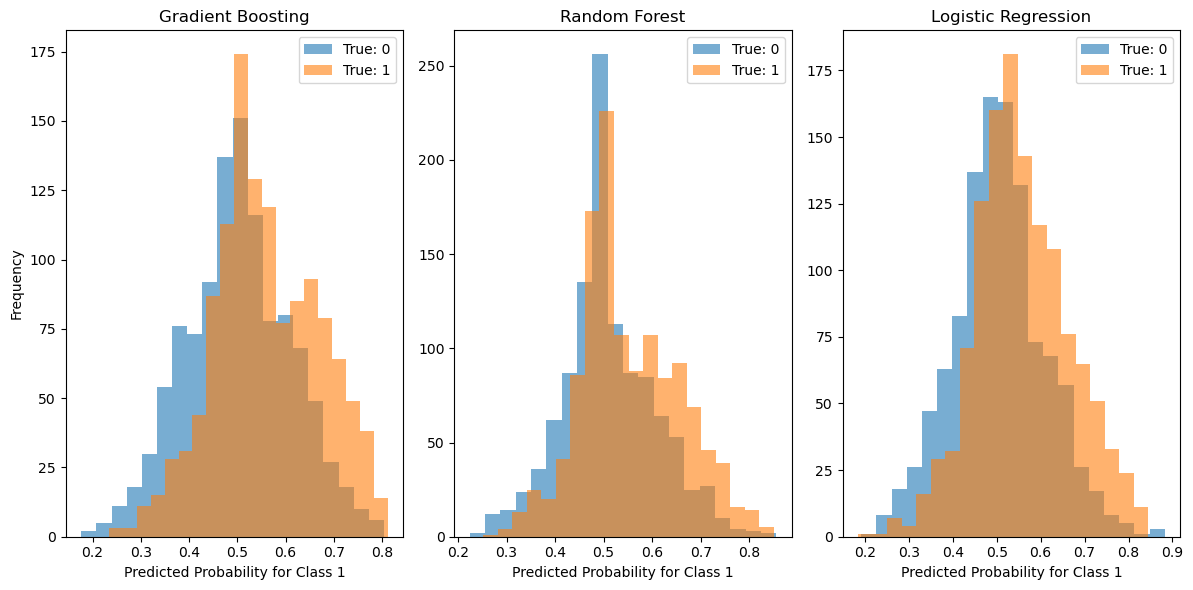

In [3]:
import matplotlib.pyplot as plt

# Extract probabilities and true labels from df
gb_class1_probs = df["GB"].values
rf_class1_probs = df["RF"].values
lr_class1_probs = df["LR"].values
y_true = df["Status"].values  # true phenotype (0/1)

plt.figure(figsize=(12, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
plt.hist(gb_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(gb_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Gradient Boosting')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(rf_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Random Forest')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

# Logistic Regression
plt.subplot(1, 3, 3)
plt.hist(lr_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(lr_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Logistic Regression')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

plt.tight_layout()
plt.show()


## 3. Correlation & Performance Plot

LR: Pearson correlation = 0.242 (p=1.155e-32)
RF: Pearson correlation = 0.214 (p=8.418e-26)
GB: Pearson correlation = 0.262 (p=2.593e-38)
GBLUP_Mean: Pearson correlation = 0.220 (p=3.921e-27)
LASSO_Mean: Pearson correlation = 0.223 (p=6.802e-28)
RKHS_Mean: Pearson correlation = 0.232 (p=4.761e-30)
EGBLUP_Mean: Pearson correlation = 0.221 (p=1.753e-27)
BRR_Mean: Pearson correlation = 0.222 (p=8.864e-28)
BayesB_Mean: Pearson correlation = 0.218 (p=1.023e-26)


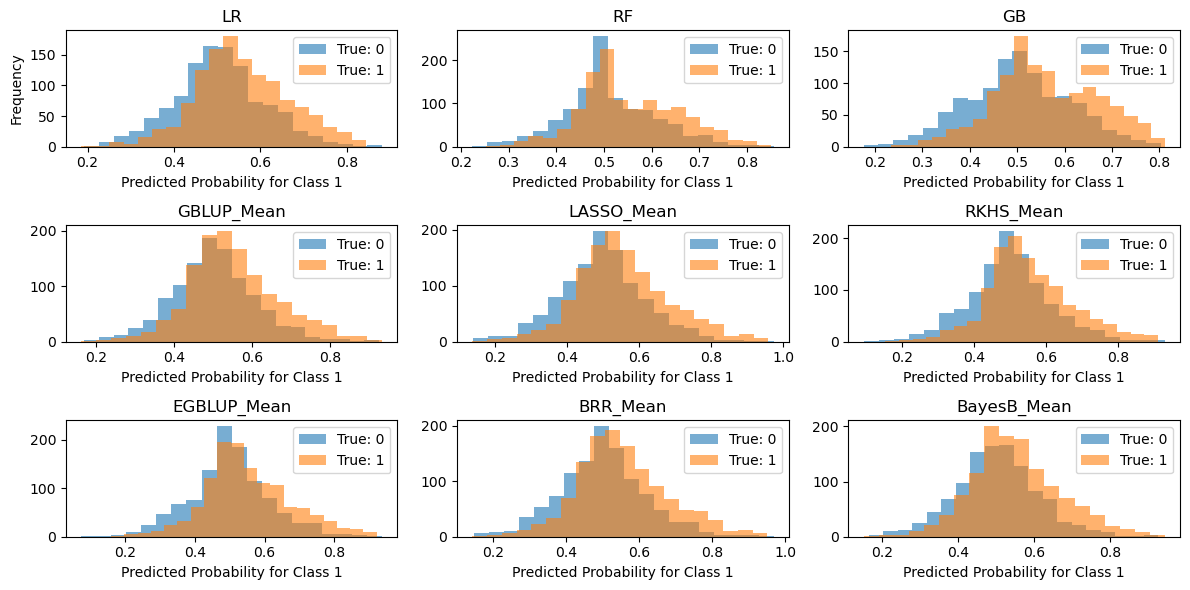

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

y_true = df["Status"].values

for model in models:
    corr, pval = pearsonr(df[model].values, y_true)
    print(f"{model}: Pearson correlation = {corr:.3f} (p={pval:.3e})")

plt.figure(figsize=(12, 6))

n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

for i, model in enumerate(models, 1):
    probs = df[model].values
    plt.subplot(n_rows, n_cols, i)
    plt.hist(probs[y_true == 0], bins=20, alpha=0.6, label="True: 0")
    plt.hist(probs[y_true == 1], bins=20, alpha=0.6, label="True: 1")
    plt.title(f"{model}")
    plt.xlabel("Predicted Probability for Class 1")
    plt.ylabel("Frequency" if i == 1 else "")
    plt.legend()

plt.tight_layout()
plt.show()


## 4. Model Correlation Plot

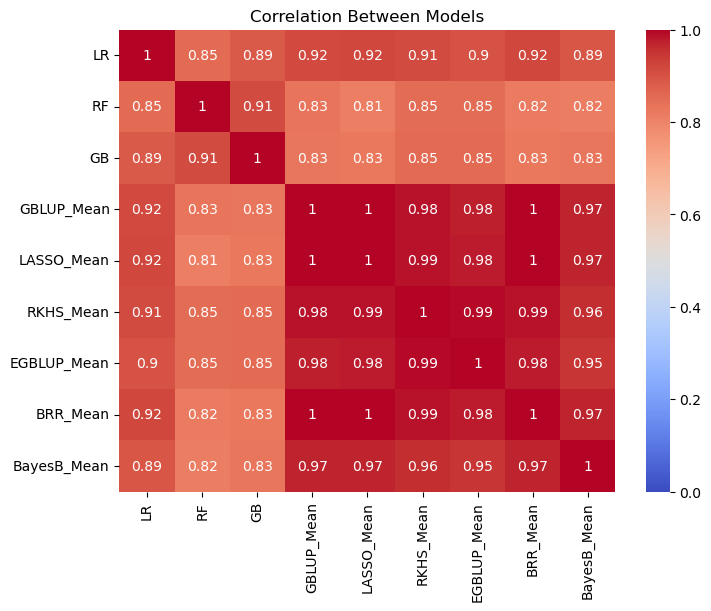

In [5]:
# Average breeding value per individual across folds
avg_preds = df.groupby('ID')[models].mean()
corr_matrix = avg_preds.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Between Models')
plt.show()

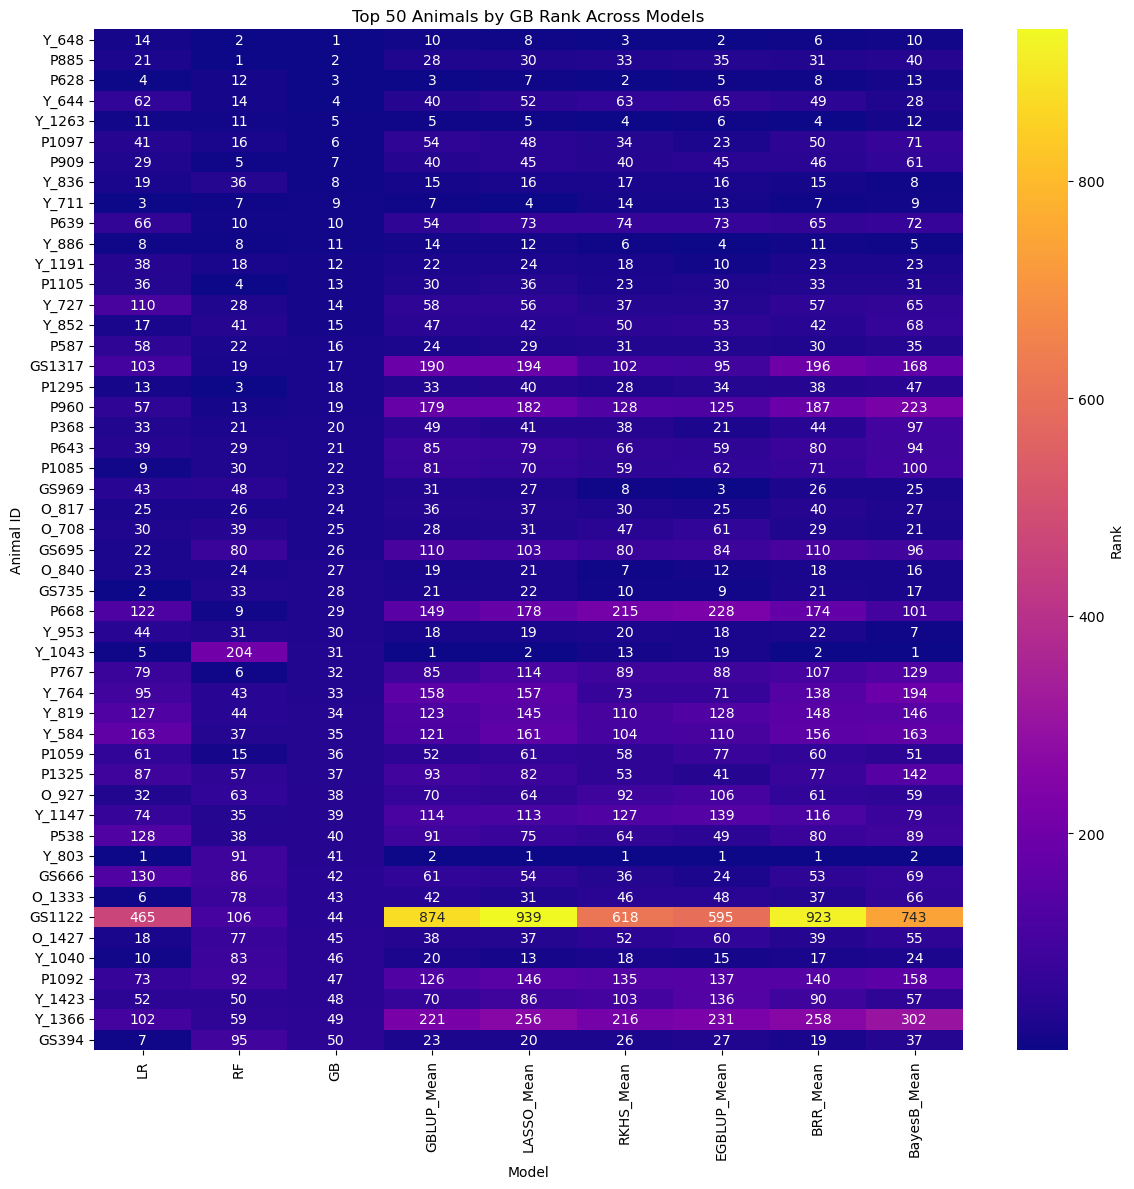

In [6]:
rank_only = df.set_index("ID").rank(ascending=False).astype(int)
rank_only = rank_only.drop('Status', axis=1)
rank_only = rank_only.reset_index()

top_n = 50
subset = rank_only.sort_values("GB").head(top_n).set_index("ID")  # or use average rank
plt.figure(figsize=(12, 12))
sns.heatmap(subset, annot=True, cmap="plasma", fmt="d", cbar_kws={'label': 'Rank'})
plt.title(f"Top {top_n} Animals by GB Rank Across Models")
plt.ylabel("Animal ID")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


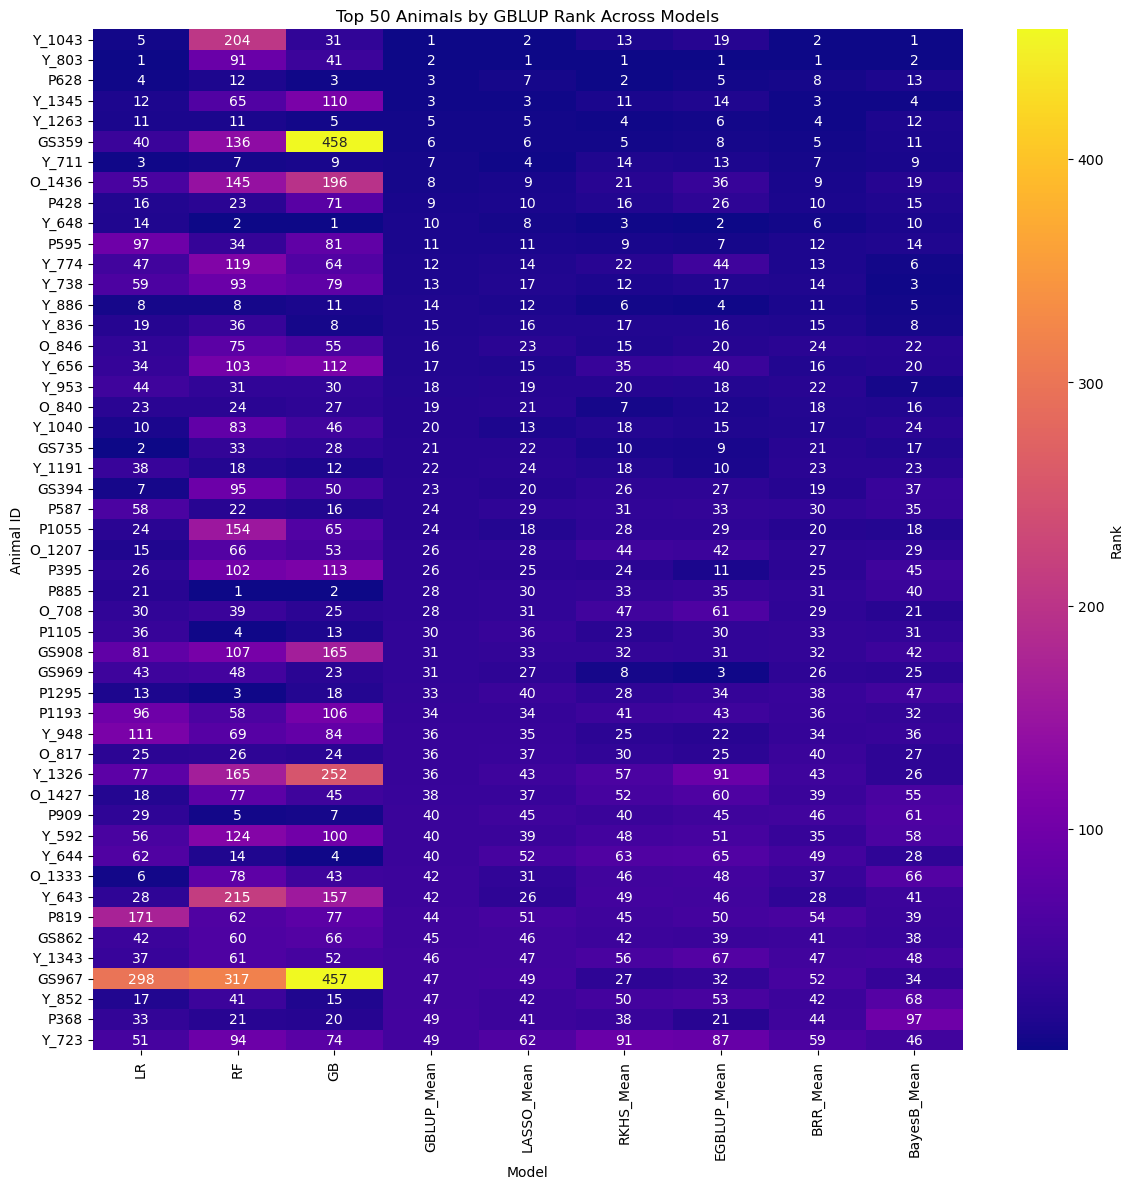

In [7]:
subset2 = rank_only.sort_values("GBLUP_Mean").head(top_n).set_index("ID")  # or use average rank
plt.figure(figsize=(12, 12))
sns.heatmap(subset2, annot=True, cmap="plasma", fmt="d", cbar_kws={'label': 'Rank'})
plt.title(f"Top {top_n} Animals by GBLUP Rank Across Models")
plt.ylabel("Animal ID")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [8]:
rank_only['GB-RKHS'] = np.abs(rank_only['RKHS_Mean'] - rank_only['GB'])
rank_only
print(np.mean(rank_only['GB-RKHS']))

rank_only['GBLUP-RKHS'] = np.abs(rank_only['RKHS_Mean'] - rank_only['GBLUP_Mean'])
rank_only
print(np.mean(rank_only['GBLUP-RKHS']))

rank_only['RF-GB'] = np.abs(rank_only['RF'] - rank_only['GB'])
rank_only
print(np.mean(rank_only['RF-GB']))


284.96139159949087
92.0296987696224
224.00424268137462


In [9]:
temp = df.copy() 
label_col = 'Status' 
model_columns = [col for col in temp.columns if col not in ['ID', label_col]]

# Initialize result containers
full_stats = []
top10_stats = []

for model in model_columns:
    # Create binary predictions using GEBV threshold
    temp[f"{model}_pred"] = (temp[model] > 0.5).astype(int)
    total_pos_rate = temp[label_col].mean() * 100
    model_pos_rate = temp[f"{model}_pred"].mean() * 100

    full_stats.append({
        'Model': model,
        '% Predicted Positives': model_pos_rate,
        '% Actual Positives': total_pos_rate
    })

    # ---------- TOP 10% ----------
    top_n = int(len(df) * 0.05)
    df_sorted = temp.sort_values(by=model, ascending=False).head(top_n)

    top_model_pos_rate = df_sorted[f"{model}_pred"].mean() * 100
    top_actual_pos_rate = df_sorted[label_col].mean() * 100

    top10_stats.append({
        'Model': model,
        '% Predicted Positives (Top 5%)': top_model_pos_rate,
        '% Actual Positives (Top 5%)': top_actual_pos_rate
    })

# Convert to DataFrames
full_stats_df = pd.DataFrame(full_stats).set_index('Model')
top10_stats_df = pd.DataFrame(top10_stats).set_index('Model')
print(full_stats_df)
print(top10_stats_df)

             % Predicted Positives  % Actual Positives
Model                                                 
LR                       61.306746           53.288078
RF                       57.276199           53.288078
GB                       60.924905           53.288078
GBLUP_Mean               58.761137           53.288078
LASSO_Mean               58.124735           53.288078
RKHS_Mean                58.633857           53.288078
EGBLUP_Mean              57.276199           53.288078
BRR_Mean                 58.167162           53.288078
BayesB_Mean              57.827747           53.288078
             % Predicted Positives (Top 5%)  % Actual Positives (Top 5%)
Model                                                                   
LR                                    100.0                    80.341880
RF                                    100.0                    76.068376
GB                                    100.0                    81.196581
GBLUP_Mean                    